In [ ]:
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

## DQN

In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import random
import gym
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from collections import deque
import matplotlib.pyplot as plt

stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.optim as optim
import random
from collections import deque
import numpy as np

In [ ]:
class StockTradingNet(nn.Module):
    def __init__(self):
        super(StockTradingNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 3)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class StockTradingAgent:
    def __init__(self, environment, batch_size=50, replay_capacity=1500, exploration_rate=1.0, exploration_decay=0.9995, discount_factor=0.9):
        self.environment = environment
        self.state_dimension = environment.observation_space.n
        self.action_dimension = environment.action_space.n
        self.replay_buffer = np.zeros((replay_capacity, 2 * self.state_dimension + 3))
        self.policy_net = StockTradingNet()
        self.target_net = StockTradingNet()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = batch_size
        self.replay_capacity = replay_capacity
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.discount_factor = discount_factor
        self.learning_step_counter = 0

    def select_action(self, state):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_state = torch.FloatTensor(one_hot_state).unsqueeze(0)
        if np.random.rand() > self.exploration_rate:
            with torch.no_grad():
                action_values = self.policy_net(one_hot_state)
                action = action_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[np.random.randint(0, self.action_dimension)]], dtype=torch.long)
        return action

    def store_transition(self, state, action, reward, next_state, done):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_next_state = np.zeros(self.state_dimension)
        one_hot_next_state[next_state] = 1
        transition = np.concatenate((one_hot_state, [action, reward], one_hot_next_state, [int(done)]))
        index = self.learning_step_counter % self.replay_capacity
        self.replay_buffer[index, :] = transition
        self.learning_step_counter += 1

    def optimize_model(self):
        if self.learning_step_counter < self.batch_size:
            return
        sample_indices = np.random.choice(min(self.replay_capacity, self.learning_step_counter), self.batch_size)
        batch = self.replay_buffer[sample_indices, :]
        state_batch = torch.FloatTensor(batch[:, :self.state_dimension])
        action_batch = torch.LongTensor(batch[:, self.state_dimension:self.state_dimension+1].astype(int))
        reward_batch = torch.FloatTensor(batch[:, self.state_dimension+1:self.state_dimension+2])
        next_state_batch = torch.FloatTensor(batch[:, self.state_dimension+2:-1])

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = self.target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        loss = self.criterion(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.exploration_rate = max(self.exploration_rate * self.exploration_decay, 0.01)

Episode: 1, Total Reward: -878.0246536669299, Account Value: 95990.54309400001, Epsilon: 0.16291280823111093
Episode: 2, Total Reward: 2330.426025342043, Account Value: 145700.28276700008, Epsilon: 0.022720922640519125
Episode: 3, Total Reward: 413.7065493045731, Account Value: 106962.478448, Epsilon: 0.01
Episode: 4, Total Reward: 7482.584860582179, Account Value: 91376.336211, Epsilon: 0.01
Episode: 5, Total Reward: -2853.910180076809, Account Value: 64081.55183500001, Epsilon: 0.01
Episode: 6, Total Reward: 185.44966451860284, Account Value: 83995.10710700005, Epsilon: 0.01
Episode: 7, Total Reward: 212.85610942697326, Account Value: 126277.96410100002, Epsilon: 0.01
Episode: 8, Total Reward: 211.67699061608218, Account Value: 103237.14643499989, Epsilon: 0.01
Episode: 9, Total Reward: 154.80361137847345, Account Value: 71976.49398299973, Epsilon: 0.01
Episode: 10, Total Reward: 159.92912936496194, Account Value: 75326.97292799996, Epsilon: 0.01
Episode: 11, Total Reward: 211.282488

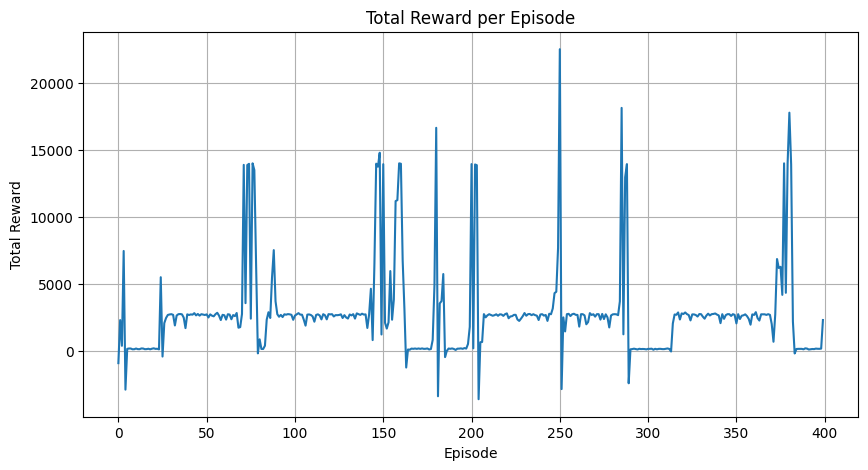

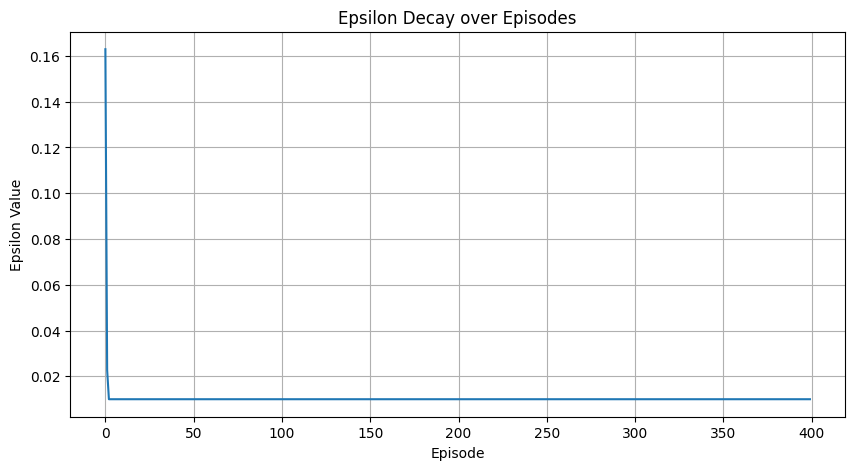

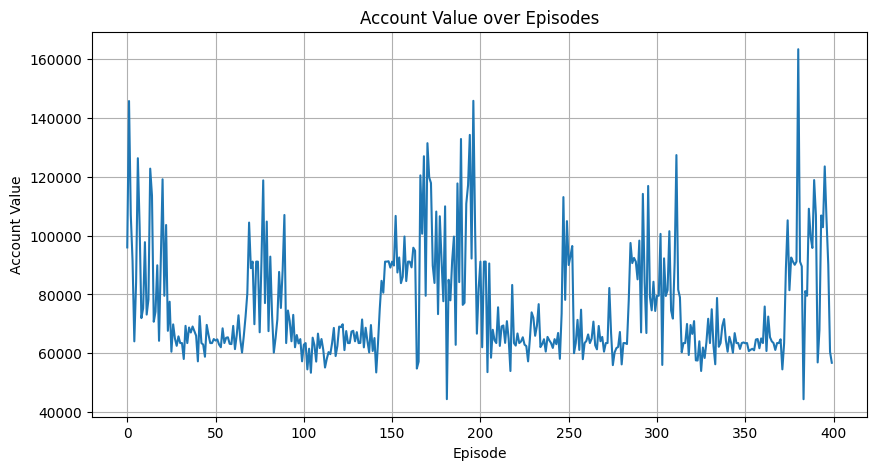

In [ ]:
import matplotlib.pyplot as plt

if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10)
    agent = StockTradingAgent(env, batch_size=32, replay_capacity=500, exploration_rate=1.0, exploration_decay=0.995, discount_factor=0.9)

    num_episodes = 400
    rewards = []
    epsilons = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)  # Decision made by the agent
            next_state, reward, done, _, _ = env.step(action.item())  # Environment reacts
            agent.store_transition(state, action.item(), reward, next_state, done)
            state = next_state
            total_reward += reward
            if len(agent.replay_buffer) > agent.batch_size:
                agent.optimize_model()

        rewards.append(total_reward)
        epsilons.append(agent.exploration_rate)
        account_values.append(env.total_account_value)  # Track account value at the end of the episode
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}, Epsilon: {agent.exploration_rate}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay over Episodes')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.title('Account Value over Episodes')
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


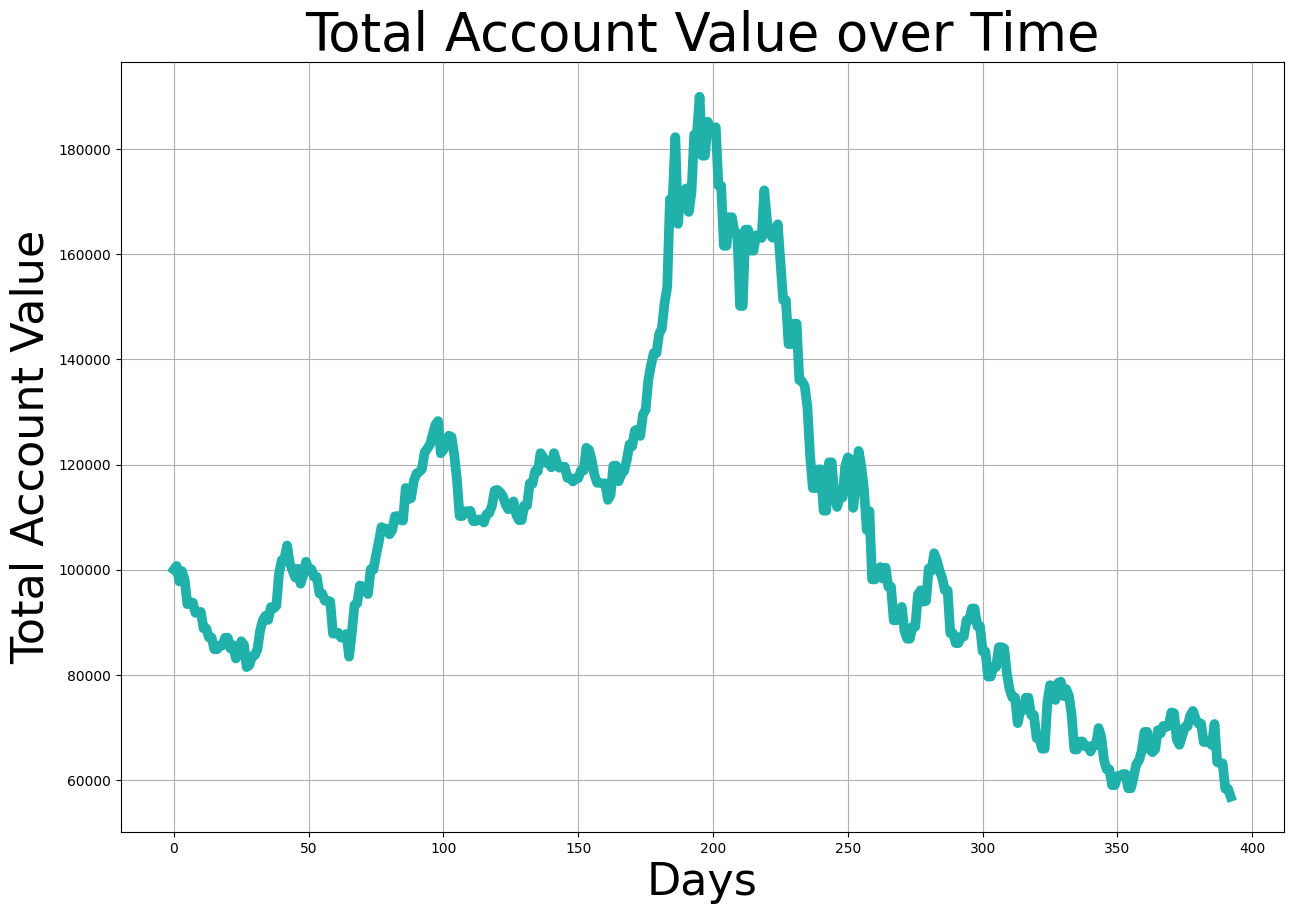

In [ ]:
env.render()

Test Episode: 1, Total Reward: -324.88780112916874, Account Value: 121130.07556799997
Test Episode: 2, Total Reward: -424.80994862057094, Account Value: 111660.35447399998
Test Episode: 3, Total Reward: -322.4617293525826, Account Value: 94768.983526
Test Episode: 4, Total Reward: -246.46050354538673, Account Value: 144202.80291799997
Test Episode: 5, Total Reward: -265.52278715328464, Account Value: 138452.5041220001


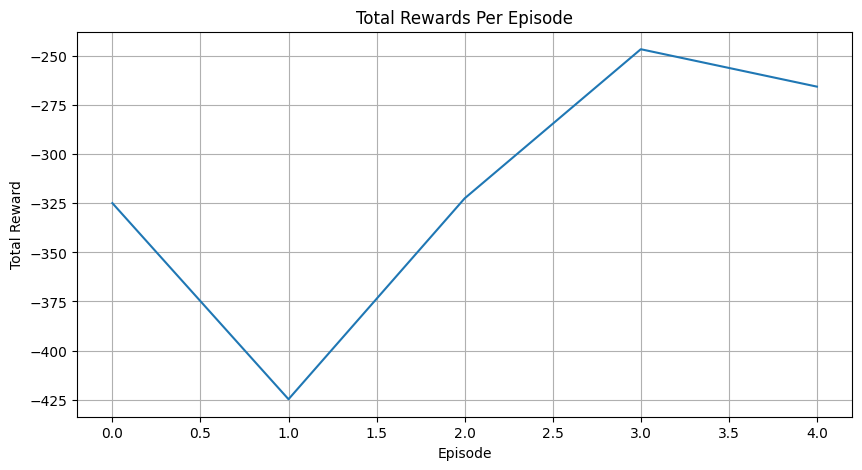

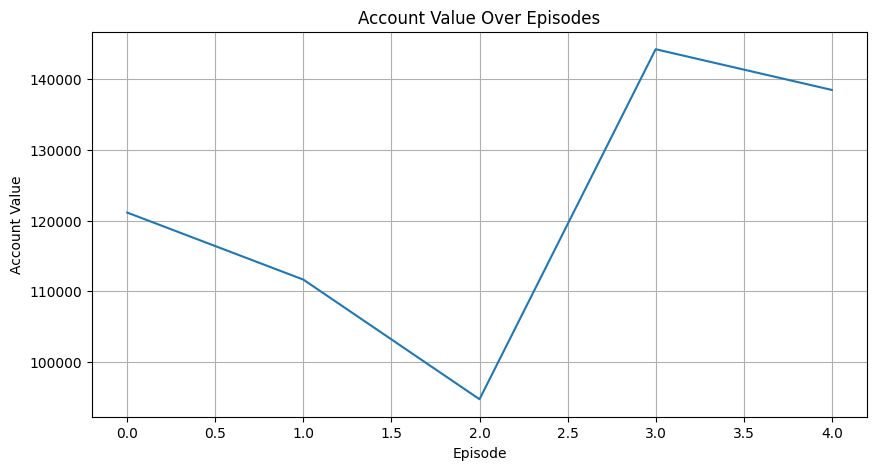

In [ ]:
def test_trained_agent(env, agent, num_episodes=80):
    """Test the trained agent for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action.item())
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")

    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    agent = StockTradingAgent(env)

    test_trained_agent(env, agent, num_episodes=5)


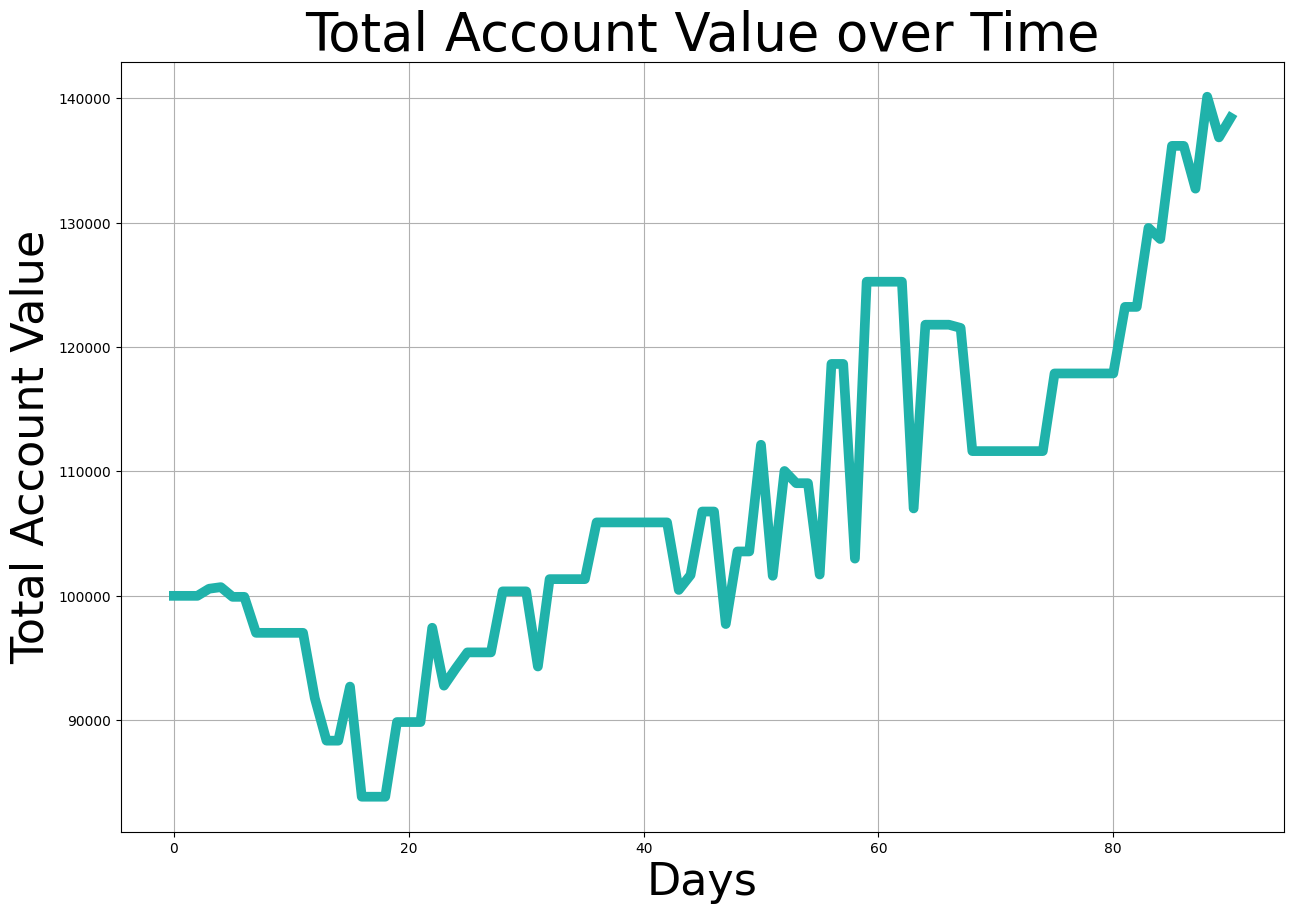

In [ ]:
env.render()

# Double - DQN

In [ ]:
class StockTradingNet(nn.Module):
    def __init__(self):
        super(StockTradingNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 3)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class StockTradingAgent:
    def __init__(self, environment, batch_size=50, replay_capacity=1500, exploration_rate=1.0, exploration_decay=0.9995, discount_factor=0.9):
        self.environment = environment
        self.state_dimension = environment.observation_space.n
        self.action_dimension = environment.action_space.n
        self.replay_buffer = np.zeros((replay_capacity, 2 * self.state_dimension + 3))
        self.policy_net = StockTradingNet()
        self.target_net = StockTradingNet()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = batch_size
        self.replay_capacity = replay_capacity
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.discount_factor = discount_factor
        self.learning_step_counter = 0

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def select_action(self, state):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_state = torch.FloatTensor(one_hot_state).unsqueeze(0)
        if np.random.rand() > self.exploration_rate:
            with torch.no_grad():
                action_values = self.policy_net(one_hot_state)
                action = action_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[np.random.randint(0, self.action_dimension)]], dtype=torch.long)
        return action

    def store_transition(self, state, action, reward, next_state, done):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_next_state = np.zeros(self.state_dimension)
        one_hot_next_state[next_state] = 1
        transition = np.concatenate((one_hot_state, [action, reward], one_hot_next_state, [int(done)]))
        index = self.learning_step_counter % self.replay_capacity
        self.replay_buffer[index, :] = transition
        self.learning_step_counter += 1

    def optimize_model(self):
        if self.learning_step_counter < self.batch_size:
            return
        sample_indices = np.random.choice(min(self.replay_capacity, self.learning_step_counter), self.batch_size)
        batch = self.replay_buffer[sample_indices, :]
        state_batch = torch.FloatTensor(batch[:, :self.state_dimension])
        action_batch = torch.LongTensor(batch[:, self.state_dimension:self.state_dimension+1].astype(int))
        reward_batch = torch.FloatTensor(batch[:, self.state_dimension+1:self.state_dimension+2])
        next_state_batch = torch.FloatTensor(batch[:, self.state_dimension+2:-1])

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        next_state_values = self.target_net(next_state_batch).gather(1, next_state_actions).detach()

        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        loss = self.criterion(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.exploration_rate = max(self.exploration_rate * self.exploration_decay, 0.01)

        if self.learning_step_counter % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


Episode: 1, Total Reward: -733.0909043843038, Account Value: 76635.43696999997, Epsilon: 0.16373146555890544
Episode: 2, Total Reward: 2915.409071188528, Account Value: 87696.17334000004, Epsilon: 0.022835098131175
Episode: 3, Total Reward: 19254.16618994492, Account Value: 143821.816687, Epsilon: 0.01
Episode: 4, Total Reward: -2194.3503668420367, Account Value: 58013.59957899999, Epsilon: 0.01
Episode: 5, Total Reward: 4843.23100523463, Account Value: 92778.297823, Epsilon: 0.01
Episode: 6, Total Reward: 2551.412088921308, Account Value: 89290.28664299998, Epsilon: 0.01
Episode: 7, Total Reward: 13994.919485864842, Account Value: 98687.899958, Epsilon: 0.01
Episode: 8, Total Reward: 12417.230815993034, Account Value: 94958.631899, Epsilon: 0.01
Episode: 9, Total Reward: 3249.933414994659, Account Value: 86170.43737299998, Epsilon: 0.01
Episode: 10, Total Reward: 13945.219123896384, Account Value: 91160.549848, Epsilon: 0.01
Episode: 11, Total Reward: 13755.998124859223, Account Value

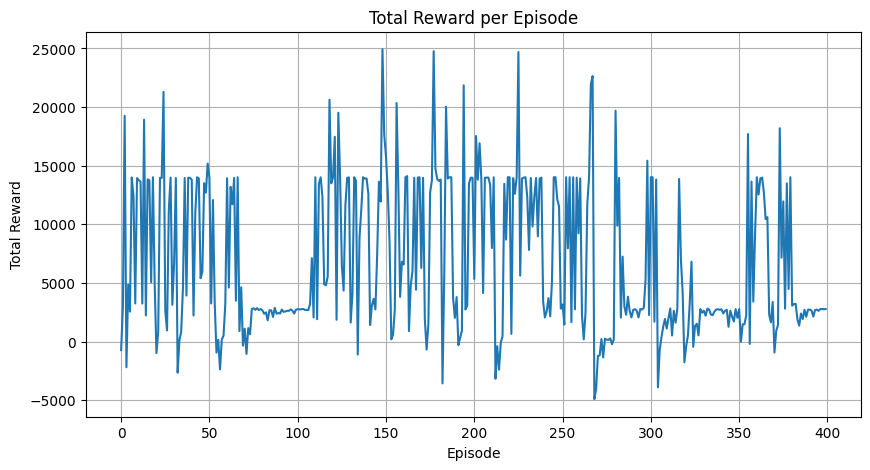

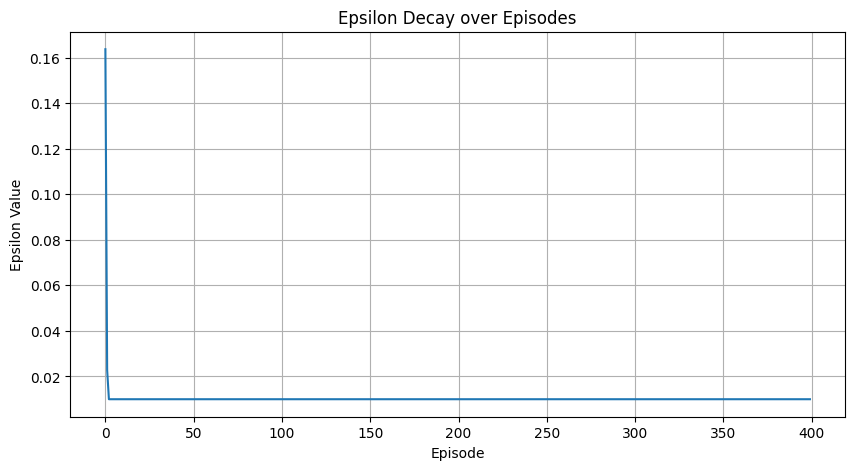

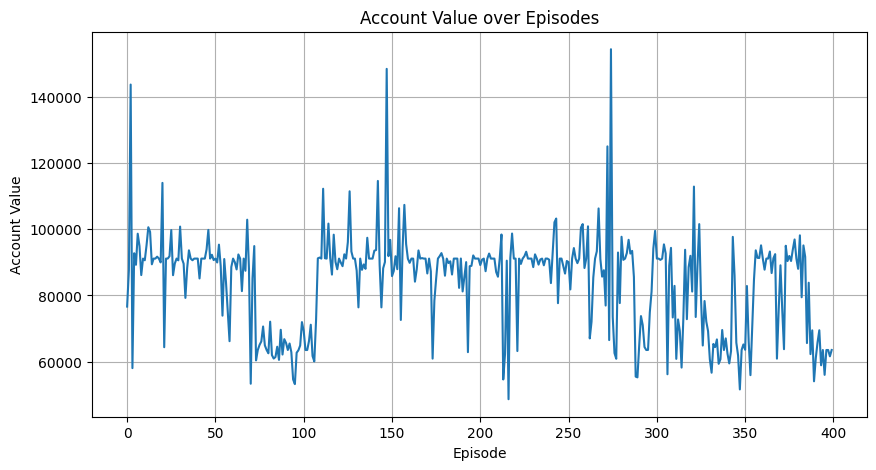

In [ ]:
if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10)
    agent = StockTradingAgent(env, batch_size=32, replay_capacity=500, exploration_rate=1.0, exploration_decay=0.995, discount_factor=0.9)

    num_episodes = 400
    rewards = []
    epsilons = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)  # Decision made by the agent
            next_state, reward, done, *_ = env.step(action.item())  # Environment reacts
            agent.store_transition(state, action.item(), reward, next_state, done)
            state = next_state
            total_reward += reward
            if agent.learning_step_counter > agent.batch_size:
                agent.optimize_model()

        rewards.append(total_reward)
        epsilons.append(agent.exploration_rate)
        account_values.append(env.total_account_value)  # Track account value at the end of the episode
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}, Epsilon: {agent.exploration_rate}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay over Episodes')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.title('Account Value over Episodes')
    plt.grid(True)
    plt.show()

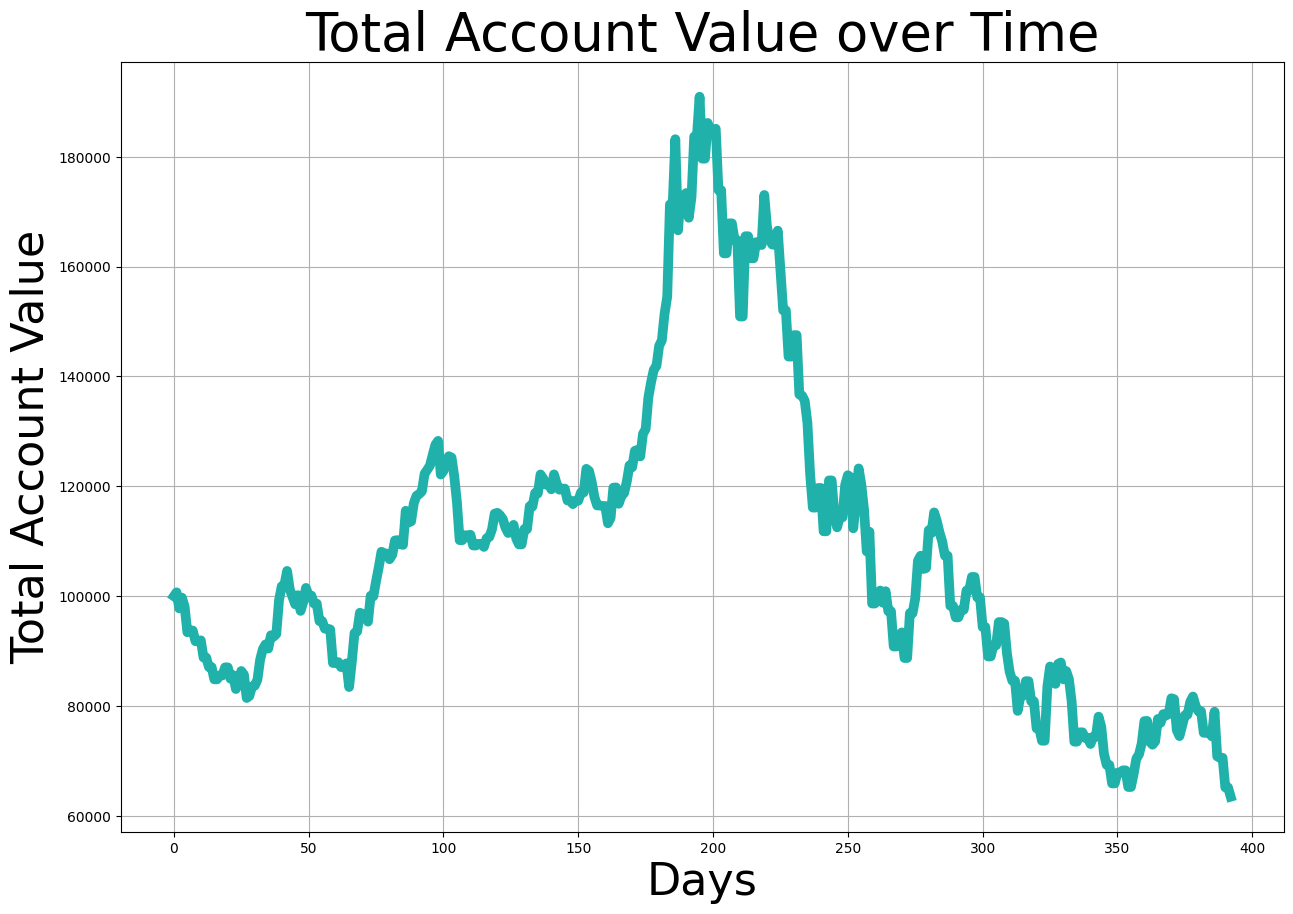

In [ ]:
env.render()

Test Episode: 1, Total Reward: -115.79872777248873, Account Value: 120082.757723
Test Episode: 2, Total Reward: -204.06098209566412, Account Value: 104859.11601499999
Test Episode: 3, Total Reward: -205.569318989086, Account Value: 163002.14633099997
Test Episode: 4, Total Reward: -267.7536150520537, Account Value: 109335.81472400004
Test Episode: 5, Total Reward: -277.82590244731523, Account Value: 149271.73397000006


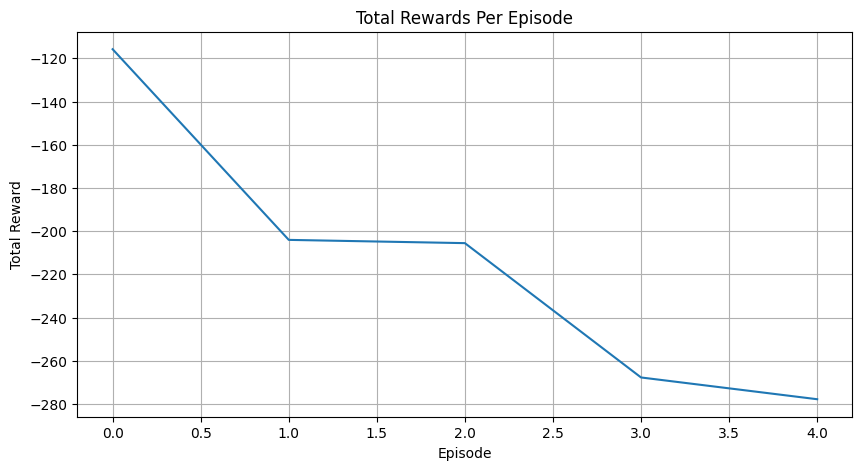

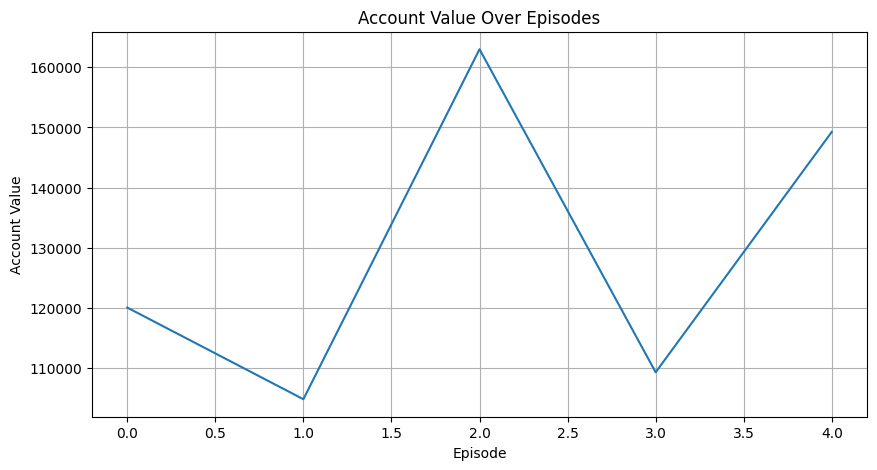

In [ ]:
def test_trained_agent(env, agent, num_episodes=80):
    """Test the trained agent for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, *_ = env.step(action.item())
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    agent = StockTradingAgent(env)
    test_trained_agent(env, agent, num_episodes=5)

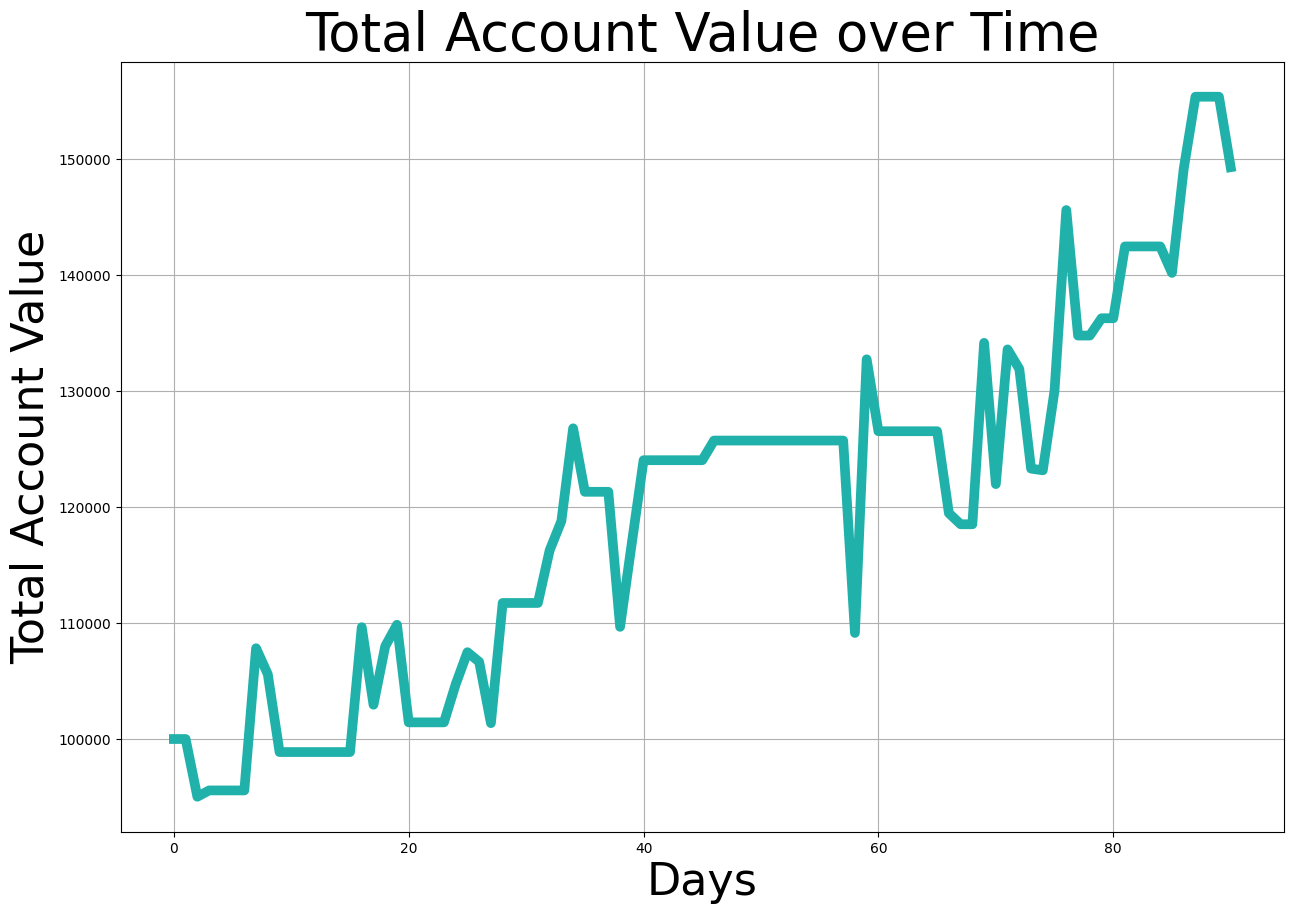

In [ ]:
env.render()

##**PER**

In [ ]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# PrioritizedReplayBuffer class
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, alpha=0.6, beta=0.4):
        self.buffer_size = buffer_size
        self.buffer = []
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)
        self.alpha = alpha
        self.beta = beta
        self.pos = 0
        self.max_priority = 1.0

    def add(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.buffer_size:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.buffer_size

    def sample(self, batch_size):
        if len(self.buffer) == self.buffer_size:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = random.choices(range(len(self.buffer)), k=batch_size, weights=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio * self.max_priority

    def set_max_priority(self, max_priority):
        self.max_priority = max_priority

In [ ]:
# Neural Network for the Stock Trading Agent
class StockTradingNet(nn.Module):
    def __init__(self):
        super(StockTradingNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 3)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Stock Trading Agent
class StockTradingAgent:
    def __init__(self, environment, batch_size=50, replay_capacity=1500, exploration_rate=1.0, exploration_decay=0.9995, discount_factor=0.9):
        self.environment = environment
        self.state_dimension = environment.observation_space.n
        self.action_dimension = environment.action_space.n
        self.replay_buffer = PrioritizedReplayBuffer(replay_capacity)
        self.policy_net = StockTradingNet()
        self.target_net = StockTradingNet()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = batch_size
        self.replay_capacity = replay_capacity
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.discount_factor = discount_factor
        self.learning_step_counter = 0
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def select_action(self, state):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_state = torch.FloatTensor(one_hot_state).unsqueeze(0)
        if np.random.rand() > self.exploration_rate:
            with torch.no_grad():
                action_values = self.policy_net(one_hot_state)
            action = action_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[np.random.randint(0, self.action_dimension)]], dtype=torch.long)
        return action

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def optimize_model(self):
        if self.learning_step_counter < self.batch_size:
            return

        samples, indices, weights = self.replay_buffer.sample(self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*samples)

        state_batch = torch.FloatTensor(np.array(state_batch))
        action_batch = torch.LongTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(np.array(next_state_batch))
        done_batch = torch.FloatTensor(done_batch)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
        next_state_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
        next_state_values = self.target_net(next_state_batch).gather(1, next_state_actions).detach().squeeze(1)

        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        loss = (state_action_values - expected_state_action_values).pow(2) * torch.FloatTensor(weights)
        loss = loss.mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.exploration_rate = max(self.exploration_rate * self.exploration_decay, 0.01)

        if self.learning_step_counter % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # Update priorities in the replay buffer
        priorities = torch.abs(state_action_values - expected_state_action_values).detach().cpu().numpy() + 1e-6
        self.replay_buffer.update_priorities(indices, priorities)

        self.learning_step_counter += 1


In [ ]:
# Load the environment
file_path = './NVDA.csv'
env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10)

# Create the agent
agent = StockTradingAgent(env, batch_size=32, replay_capacity=500, exploration_rate=1.0, exploration_decay=0.995, discount_factor=0.9)


Episode: 1, Total Reward: -1385.9188117451931, Account Value: 97471.45852999989
Episode: 2, Total Reward: -1395.5081094069292, Account Value: 64682.47144900007
Episode: 3, Total Reward: -1247.9204276636071, Account Value: 89199.79927999988
Episode: 4, Total Reward: -1093.0123237996593, Account Value: 191980.62994800005
Episode: 5, Total Reward: -1152.8679065373906, Account Value: 78620.81735199987
Episode: 6, Total Reward: -1239.3105010264233, Account Value: 112992.127547
Episode: 7, Total Reward: -1256.3120408557195, Account Value: 90417.71457300012
Episode: 8, Total Reward: -1481.898492196922, Account Value: 74921.01118199989
Episode: 9, Total Reward: -1237.923611673417, Account Value: 160678.1661929999
Episode: 10, Total Reward: -1206.074945027711, Account Value: 119032.56025099994
Episode: 11, Total Reward: -1538.260451953406, Account Value: 76384.09274399995
Episode: 12, Total Reward: -1211.1421874195082, Account Value: 130380.091109
Episode: 13, Total Reward: -1292.824951306334, 

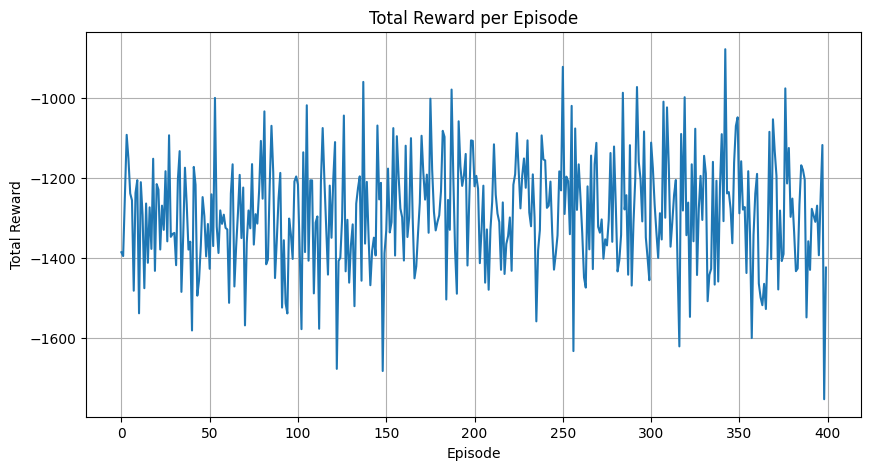

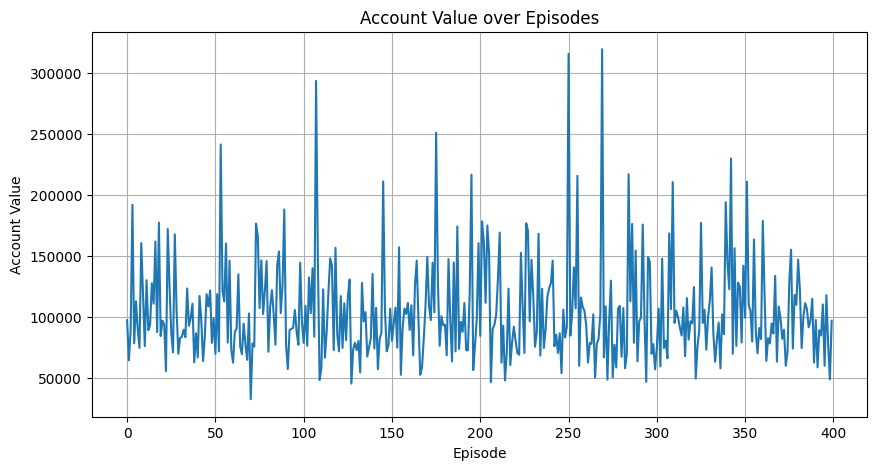

In [ ]:
# Training loop
num_episodes = 400
rewards = []
epsilons = []
account_values = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, *_ = env.step(action.item())
        agent.store_transition(state, action.item(), reward, next_state, done)
        state = next_state
        total_reward += reward

        if agent.learning_step_counter > agent.batch_size:
            agent.optimize_model()

    rewards.append(total_reward)
    epsilons.append(agent.exploration_rate)
    account_values.append(env.total_account_value)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


# Plot the total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

# Plot the account value over episodes
plt.figure(figsize=(10, 5))
plt.plot(account_values)
plt.xlabel('Episode')
plt.ylabel('Account Value')
plt.title('Account Value over Episodes')
plt.grid(True)
plt.show()

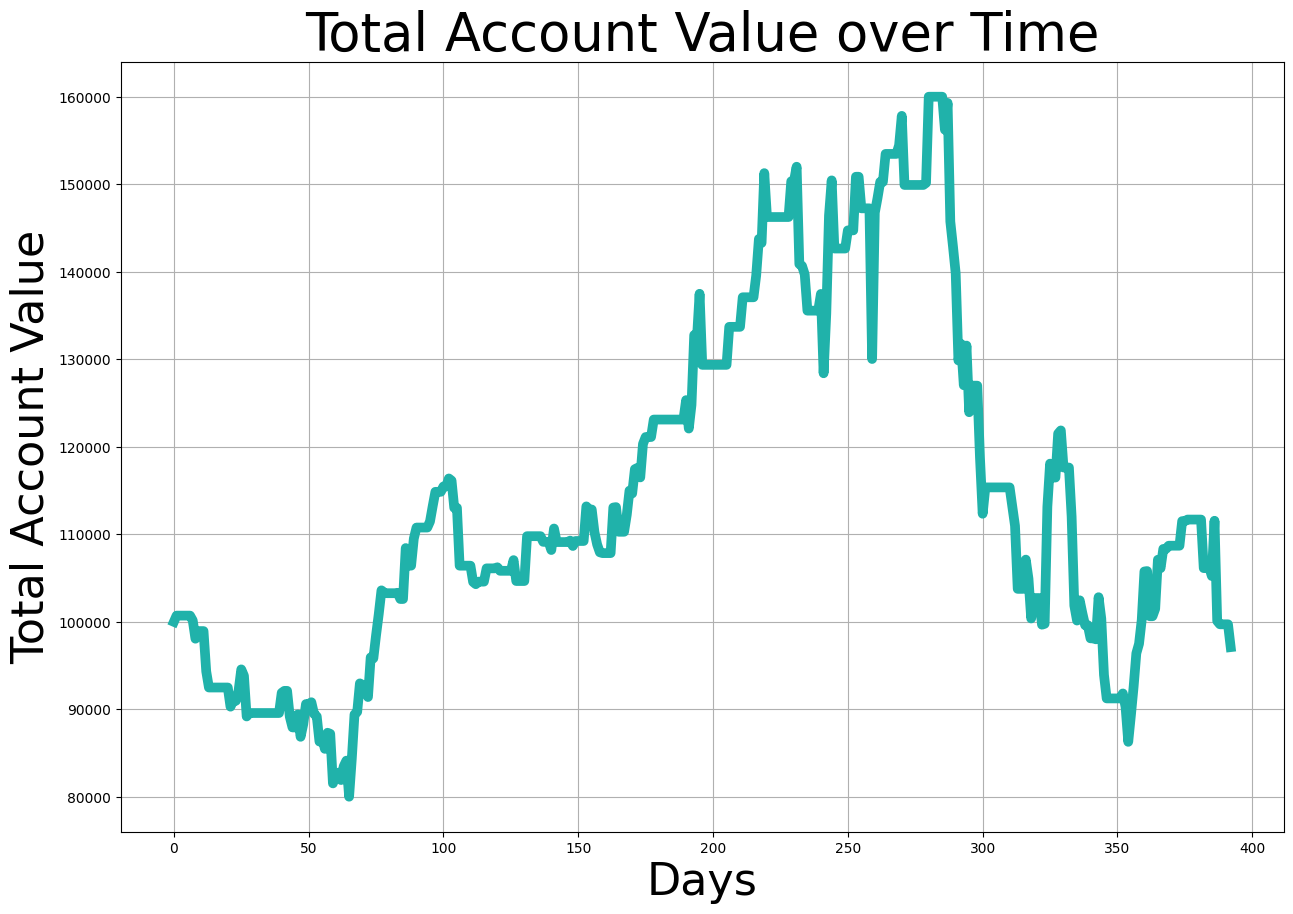

In [ ]:
env.render()

Test Episode: 1, Total Reward: -178.22562413395403, Account Value: 144488.3940949999
Test Episode: 2, Total Reward: -284.21244217912636, Account Value: 141607.176141
Test Episode: 3, Total Reward: -304.07848668519296, Account Value: 113821.81101799996
Test Episode: 4, Total Reward: -272.67058615422684, Account Value: 128743.048924
Test Episode: 5, Total Reward: -270.9803633403049, Account Value: 125352.08702999997


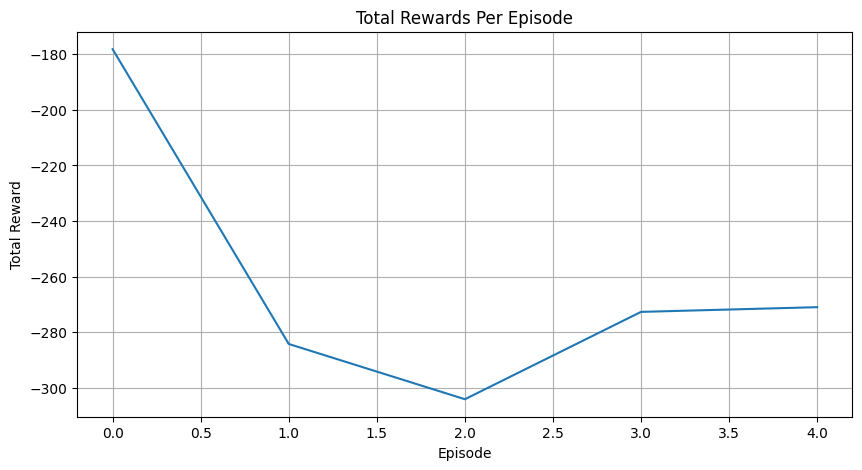

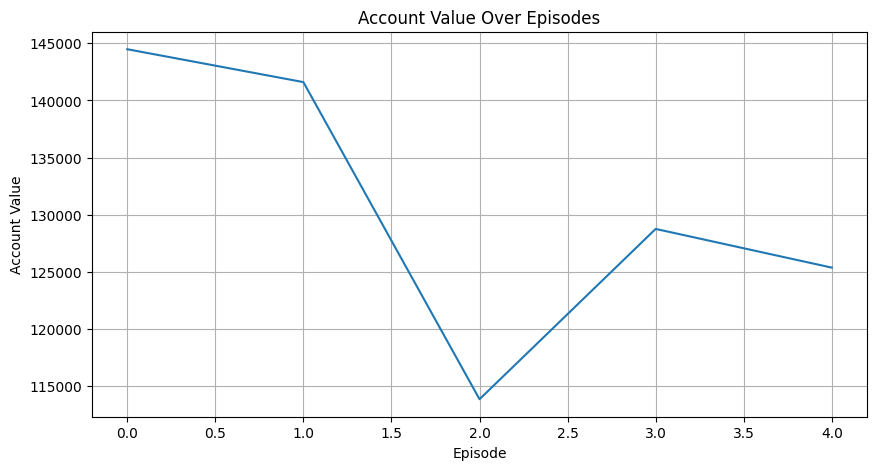

In [ ]:
def test_trained_agent(env, agent, num_episodes=80):
    """Test the trained agent for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, *_ = env.step(action.item())
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")

    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    agent = StockTradingAgent(env)
    test_trained_agent(env, agent, num_episodes=5)


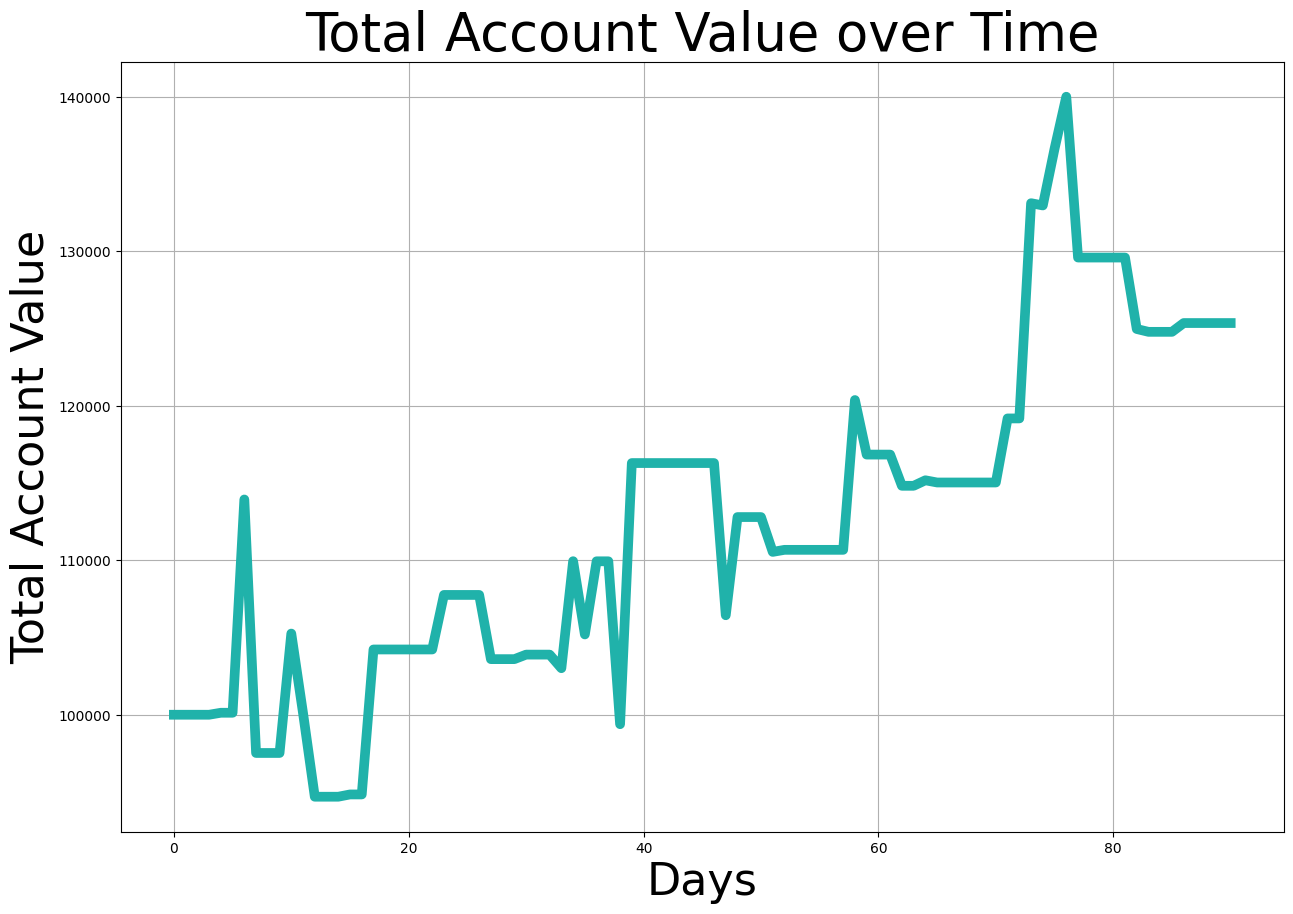

In [ ]:
env.render()